In [1]:
pip install git+https://github.com/uremes/elfi@extend_model

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/uremes/elfi (to revision extend_model) to /run/nvme/job_22883879/tmp/pip-req-build-9b5zwdwj
  Running command git clone --filter=blob:none --quiet https://github.com/uremes/elfi /run/nvme/job_22883879/tmp/pip-req-build-9b5zwdwj
  Running command git checkout -b extend_model --track origin/extend_model
  Switched to a new branch 'extend_model'
  branch 'extend_model' set up to track 'origin/extend_model'.
  Resolved https://github.com/uremes/elfi to commit 3b72621f57fb69b13053506942c20fcddda16963
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install graphviz

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import elfi

In [4]:
import graphviz

In [5]:
import simulator

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
seed = 20170530
np.random.seed(seed)

In [8]:
pdic, t_samples, D = simulator.load()

In [9]:
pdic

{'p': 4.5887449031309435,
 'beta': 2.814077673370424e-06,
 'gamma': 0.5,
 'prna': 1071.519305237606,
 'tauE': 7,
 'tauI': 41,
 'nE': 60,
 'nI': 60,
 'c': 0.0573,
 'crna': 0.001,
 'Nx': 1900000.0,
 'S': 10.0,
 'Nxassay': 100000.0,
 'Vinoc': 0.05,
 'Vvir': 5.236e-16,
 'MOIsc': 3.0,
 'V0pr': 1000000.0,
 'V0mc': 61.65950018614822,
 'V0scrna': 9332543007.969925,
 'V0prrna': 5754399.373371567,
 'V0mcrna': 10471.285480508985,
 'sigma_MC_RNA': 0.258,
 'sigma_SC_RNA': 0.237,
 'frinse': 0.95,
 'lim': 1.494}

In [10]:
para_true={'p': np.log10(pdic['p']),
 'beta': np.log10(pdic['beta']),
 'gamma': np.log10(pdic['gamma']),
 'prna': np.log10(pdic['prna']),
 'tauE': 7,
 'tauI': 41}

In [11]:
test_output = simulator.run(pdic, t_samples, D)

In [12]:
setup = pdic, t_samples, D   # base params, sample times, dilutions

In [13]:
# rewrite the simulator as paramter based function

In [14]:
def meanfield_simulator(gamma, p, beta, prna, tauE, tauI, setup, batch_size=1, random_state=None):

    pdic, t_samples, D = setup  # base params, sample times, dilutions

    pdic_para={'gamma': 10**gamma, 'p': 10**p, 'beta': 10**beta, 'prna': 10**prna, 'tauE': tauE, 'tauI': tauI}
    pdic.update(pdic_para)

    list_output = simulator.run(pdic, t_samples, D)
    return list_output

In [15]:
test_sim = meanfield_simulator(gamma=np.log10(pdic['gamma']), p=np.log10(pdic['p']), beta=np.log10(pdic['beta']), prna=np.log10(pdic['prna']), tauE=pdic['tauE'], tauI=pdic['tauI'], setup=setup, batch_size=1, random_state=None)

In [16]:
# load experimental data here

In [17]:
base = 'psimon-sH1N1/sH1N1_'
obs_dat_MC_ED = np.loadtxt(base+'MC_ED.dat')
obs_dat_MC_RNA = np.loadtxt(base+'MC_RNA.dat')
obs_dat_SC_ED = np.loadtxt(base+'SC_ED.dat')
obs_dat_SC_RNA = np.loadtxt(base+'SC_RNA.dat')
obs_dat_multi = obs_dat_MC_ED, obs_dat_MC_RNA, obs_dat_SC_ED, obs_dat_SC_RNA # the original multi sample experimental data

In [18]:
times_MC_ED, counts_MC_ED = np.unique(obs_dat_MC_ED[:, 0], return_counts=True)
times_SC_ED, counts_SC_ED = np.unique(obs_dat_SC_ED[:, 0], return_counts=True)

In [19]:
times_MC_RNA, counts_MC_RNA = np.unique(obs_dat_MC_RNA[:, 0], return_counts=True)
times_SC_RNA, counts_SC_RNA = np.unique(obs_dat_SC_RNA[:, 0], return_counts=True)

In [20]:
counts = counts_MC_ED, counts_MC_RNA, counts_SC_ED, counts_SC_RNA

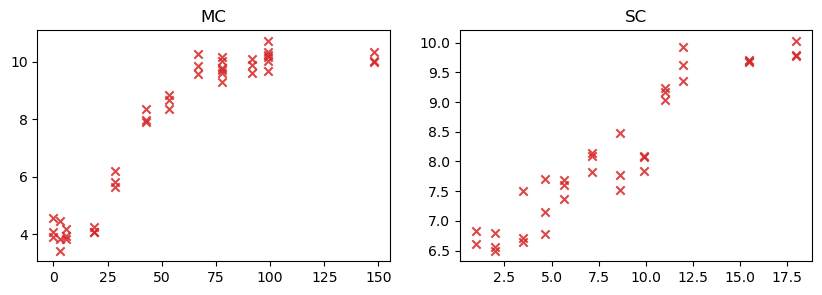

In [21]:
f, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].scatter(obs_dat_multi[1][:, 0], np.log10(obs_dat_multi[1][:, 1]), color='C3', alpha=0.85, marker='x')
ax[1].scatter(obs_dat_multi[3][:, 0], np.log10(obs_dat_multi[3][:, 1]), color='C3', alpha=0.85, marker='x')
ax[0].set_title('MC')
ax[1].set_title('SC');

create multi simulator

In [22]:
# setup, counts and fout_all are used as meanfield_simulator_multi input 

In [23]:
setup = pdic, t_samples, D   # base params, sample times, dilutions
counts = counts_MC_ED, counts_MC_RNA, counts_SC_ED, counts_SC_RNA # counts defined here

like_MC_ED = np.zeros((len(times_MC_ED), 17))
like_SC_ED = np.zeros((len(times_SC_ED), 17))
like_MC_RNA = np.ones((len(times_MC_RNA), 2))
like_SC_RNA = np.ones((len(times_SC_RNA), 2))
fout_all = [like_MC_ED, like_MC_RNA, like_SC_ED, like_SC_RNA] # fout defined here, fout=fout_all, used to replace failed simulation

In [24]:
def meanfield_simulator_multi(gamma, p, beta, prna, tauE, tauI, setup, counts, fout, batch_size=1, random_state=None):

    pdic, t_samples, D = setup  # base params, sample times, dilutions

    pdic_para={'gamma': 10**gamma, 'p': 10**p, 'beta': 10**beta, 'prna': 10**prna, 'tauE': tauE, 'tauI': tauI}
    pdic.update(pdic_para)

    list_output1 = simulator.run(pdic, t_samples, D)
    list_output2 = simulator.run(pdic, t_samples, D)
    list_output3 = simulator.run(pdic, t_samples, D)
    list_output4 = simulator.run(pdic, t_samples, D)
    list_output5 = simulator.run(pdic, t_samples, D)
    list_output6 = simulator.run(pdic, t_samples, D)

    list_all = [list_output1, list_output2, list_output3, list_output4, list_output5, list_output6]
    
    # process failed simulations
    failed = np.any([out[0] is None for out in list_all])
    list_all = [out if out[0] is not None else fout for out in list_all]

    #for ED data
    counts_MC_ED, counts_MC_RNA, counts_SC_ED, counts_SC_RNA = counts
    assert(np.all(counts_MC_ED == 3))
    assert(np.all(counts_SC_ED == 3))
    MC_ED_all = [list_output[0] for list_output in list_all[:3]]
    sim_dat_MC_ED_m = np.stack(MC_ED_all).reshape((-1, 17), order='F') # m for 'multi'
    SC_ED_all = [list_output[2] for list_output in list_all[:3]]
    sim_dat_SC_ED_m = np.stack(SC_ED_all).reshape((-1, 17), order='F')

    #for RNA data
    MC_RNA_all = [[list_output[1][ind] for list_output in list_all[:counts_MC_RNA[ind]]] for ind in range(len(counts_MC_RNA))]
    SC_RNA_all = [[list_output[3][ind] for list_output in list_all[:counts_SC_RNA[ind]]] for ind in range(len(counts_SC_RNA))]
    sim_dat_MC_RNA_m = np.vstack([np.array(MC_RNA).reshape(-1, 2) for MC_RNA in MC_RNA_all])
    sim_dat_SC_RNA_m = np.vstack([np.array(SC_RNA).reshape(-1, 2) for SC_RNA in SC_RNA_all])

    # in the original simultor output, list_ouput = sim_dat_MC_ED, sim_dat_MC_RNA, sim_dat_SC_ED, sim_dat_SC_RNA
    list_output = [sim_dat_MC_ED_m, sim_dat_MC_RNA_m, sim_dat_SC_ED_m, sim_dat_SC_RNA_m, failed]  # failed is place in the last column
    return list_output

In [25]:
# creat synthetic data:
#using pdic parameter values as input 

In [26]:
sim_dat_multi = meanfield_simulator_multi(gamma=np.log10(pdic['gamma']), p=np.log10(pdic['p']), beta=np.log10(pdic['beta']), prna=np.log10(pdic['prna']), tauE=pdic['tauE'], tauI=pdic['tauI'], setup=setup, counts=counts, fout=fout_all, batch_size=1, random_state=None)
# use this is the same as using test_output, just each time the output is different

prior

In [27]:
import operator

In [28]:
bounds = {}
bounds['gamma'] = (-1, 0.5)  # 0.1...1 
bounds['p'] = (0.2, 3)
bounds['beta'] = (-8, -2)
bounds['prna'] = (2, 6)
bounds['tauE'] = (2, 15)
bounds['tauI'] = (2, 65)

In [29]:
m = elfi.ElfiModel(name='MFM')
gamma = elfi.Prior('uniform', bounds['gamma'][0], bounds['gamma'][1]-bounds['gamma'][0], model=m)
beta = elfi.Prior('uniform', bounds['beta'][0], bounds['beta'][1]-bounds['beta'][0], model=m)
tauE=elfi.Prior('uniform', bounds['tauE'][0], bounds['tauE'][1]-bounds['tauE'][0], model=m)
tauI=elfi.Prior('uniform', bounds['tauI'][0], bounds['tauI'][1]-bounds['tauI'][0], model=m)
prna = elfi.Prior('uniform', bounds['prna'][0], bounds['prna'][1]-bounds['prna'][0], model=m)
upper_p = elfi.Operation(np.minimum, prna, bounds['p'][1])  # update upper bound based on prna
scale_p = elfi.Operation(operator.sub, upper_p, bounds['p'][0])  # calculate scale based on lower and upper bounds
p = elfi.Prior('uniform', bounds['p'][0], scale_p)
#p = elfi.Prior('uniform', bounds['p'][0], bounds['p'][1]-bounds['p'][0], model=m)

important: observed data is defined here.
if we want to use single experimental data, change the observed to "obs_dat_multi" instead of test_output here.

In [30]:
meanfield_sim_vec = elfi.tools.vectorize(meanfield_simulator_multi, dtype=False)

In [32]:
# if want to use synthetic data
list_output = elfi.Simulator(meanfield_sim_vec, gamma, p, beta, prna, tauE, tauI, setup, counts, fout_all, observed=[sim_dat_multi]) #changed observed

In [33]:
m.parameter_names

['beta', 'gamma', 'p', 'prna', 'tauE', 'tauI']

In [34]:
def get_MC_ED_data(list_output):
    X = np.array([out[0][:, -8:] for out in list_output])
    return X

def get_MC_RNA_data(list_output):
    X = np.array([out[1][:, 1] for out in list_output])
    return X

def get_SC_ED_data(list_output):
    X = np.array([out[2][:, -8:] for out in list_output])
    return X

def get_SC_RNA_data(list_output):
    X = np.array([out[3][:, 1] for out in list_output])
    return X


s1 = elfi.Summary(get_MC_ED_data, list_output)
s2 = elfi.Summary(get_MC_RNA_data, list_output)
s3 = elfi.Summary(get_SC_ED_data, list_output)
s4 = elfi.Summary(get_SC_RNA_data, list_output)

In [35]:
def get_failed(list_output):
    failed = np.array([out[4] for out in list_output])  # failed was placed in the last column in list_output
    return failed

failed = elfi.Summary(get_failed, list_output)

distance

In [36]:
from functools import partial

In [37]:
def arr_dist(arr, observed, norm=1):
    """L1 distance between simulated and observed array.

    Parameters
    ----------
    arr : np.array size (batch_size, d1, d2)
    observed : tuple (arr, ) where arr is np.array size (1, d1, d2)
    norm : float normalisation constant

    Returns
    -------
    np.array (batch_size,)

    """
    return np.sum(np.abs(arr - observed[0]), axis=(1, 2)) / norm

In [38]:
d1 = elfi.Discrepancy(partial(arr_dist, norm=3*12), s1)
d3 = elfi.Discrepancy(partial(arr_dist, norm=3*12), s3)
c2 = elfi.Summary(np.log10, s2)
c4 = elfi.Summary(np.log10, s4)
d2 = elfi.Distance('euclidean', c2)
d4 = elfi.Distance('euclidean', c4)
d13 = elfi.Operation(operator.add, d1, d3)
d24 = elfi.Operation(operator.add, d2, d4)
d = elfi.Operation(operator.add, d13, d24)

In [39]:
def extract_mean_std(vals, mean, std):
  return (vals - mean)/std

In [40]:
d_norm = elfi.Operation(extract_mean_std, d, 20, 10)

In [41]:
def mask_failures(dist, mask, failed_output=np.inf):
    dist[mask] = failed_output
    return dist

In [42]:
d_masked = elfi.Operation(mask_failures, d_norm, failed)

surrogate model

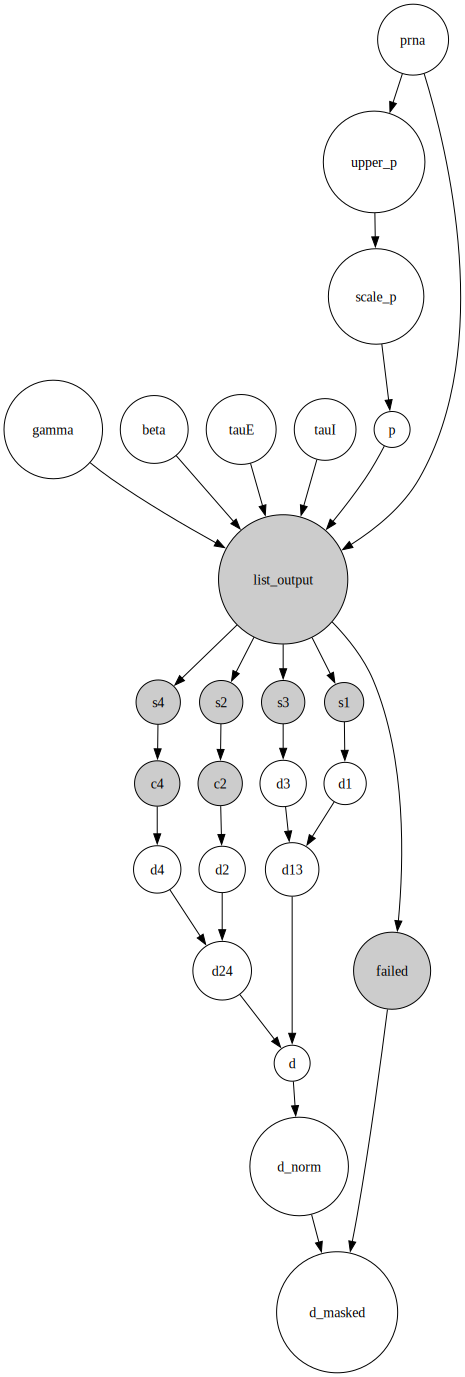

In [43]:
elfi.draw(d)

In [44]:
import GPy

In [45]:
dim = len(m.parameter_names)
kernel = GPy.kern.RBF(input_dim=dim, ARD=True)
# initialise lengthscale parameters and set prior
kernel.lengthscale = 0.2
kernel.lengthscale.set_prior(GPy.priors.Gamma(2, 5), warning=False)
# tauI is expected to have a much larger lengthscale
kernel.lengthscale[[-1]] = 6
kernel.lengthscale[[-1]].set_prior(GPy.priors.Gamma(2, 0.2), warning=False)
kernel = kernel + GPy.kern.Bias(input_dim=dim)

BOLFI with failter detection

In [46]:
target_model = elfi.RobustGPyRegression(m.parameter_names, bounds=bounds, kernel=kernel.copy(), clf_kernel=kernel.copy(), train_classifier=True, thd=0.1)

In [47]:
prior = elfi.model.extensions.ModelPrior(m)
acq = elfi.methods.bo.acquisition.MaxVar(model=target_model, prior=prior)

In [48]:
bolfi_2 = elfi.BOLFI(d_masked, batch_size=1, initial_evidence=200, update_interval=10, bounds=bounds, acq_noise_var=0.1, seed=seed, target_model=target_model, acquisition_method=acq)

In [49]:
%time post = bolfi_2.fit(n_evidence=1000)

 /users/yingying/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning:The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


 /users/yingying/.local/lib/python3.10/site-packages/paramz/transformations.py:119: RuntimeWarning:overflow encountered in expm1


 /users/yingying/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide
 /users/yingying/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Progress [==================================================] 100.0% Complete
CPU times: user 1h 52min 40s, sys: 12.9 s, total: 1h 52min 53s
Wall time: 1h 54min 32s


In [50]:
np.savez('virology_GPmodel_bolfi_synthetic_n1000_wider_Aug25.npz', X=bolfi_2.target_model.X, Y=bolfi_2.target_model.Y, params=bolfi_2.target_model.instance.param_array)

In [51]:
optim_result = bolfi_2.extract_result()
optim_result.x_min

{'beta': array([-5.91572497]),
 'gamma': array([-0.0819283]),
 'p': array([0.57642354]),
 'prna': array([3.10418258]),
 'tauE': array([6.75358683]),
 'tauI': array([25.51382711])}

In [52]:
post.threshold

-0.9687656671715711

check the regression and classifier components:

In [53]:
bolfi_2.target_model._gp

GP_regression.,value,constraints,priors
sum.rbf.variance,0.8198409983292146,+ve,
sum.rbf.lengthscale,"(6,)",+ve,"{Ga(2, 5)} {Ga(2, 0.2)}"
sum.bias.variance,2.340268835209562,+ve,
Gaussian_noise.variance,0.003496751856932156,+ve,


In [54]:
bolfi_2.target_model._gp.sum.rbf.lengthscale

index,GP_regression.sum.rbf.lengthscale,constraints,priors
[0],1.51607622,+ve,"Ga(2, 5)"
[1],1.31929211,+ve,"Ga(2, 5)"
[2],1.39541133,+ve,"Ga(2, 5)"
[3],1.94609523,+ve,"Ga(2, 5)"
[4],7.41808870,+ve,"Ga(2, 5)"
[5],42.07701337,+ve,"Ga(2, 0.2)"


In [56]:
bolfi_2.target_model._clf.sum.rbf.lengthscale

index,gp_classification.sum.rbf.lengthscale,constraints,priors
[0],0.86603965,+ve,"Ga(2, 5)"
[1],0.16612015,+ve,"Ga(2, 5)"
[2],3.17405083,+ve,"Ga(2, 5)"
[3],3.98342808,+ve,"Ga(2, 5)"
[4],7.24862614,+ve,"Ga(2, 5)"
[5],81.96916123,+ve,"Ga(2, 0.2)"


plot:

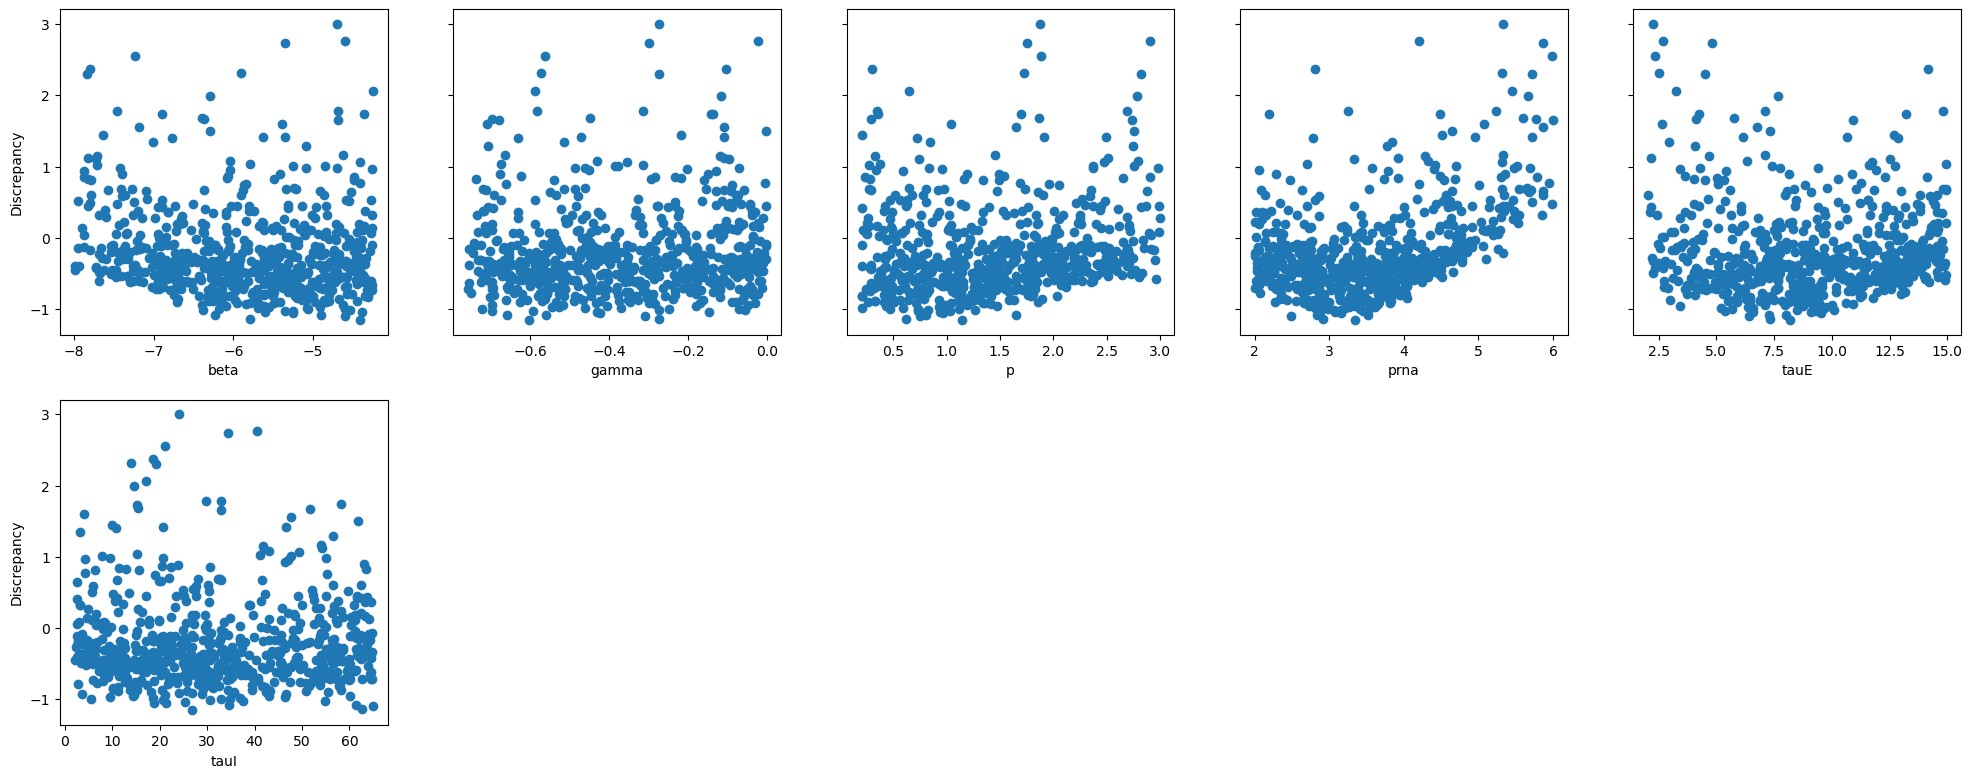

In [57]:
bolfi_2.plot_discrepancy();

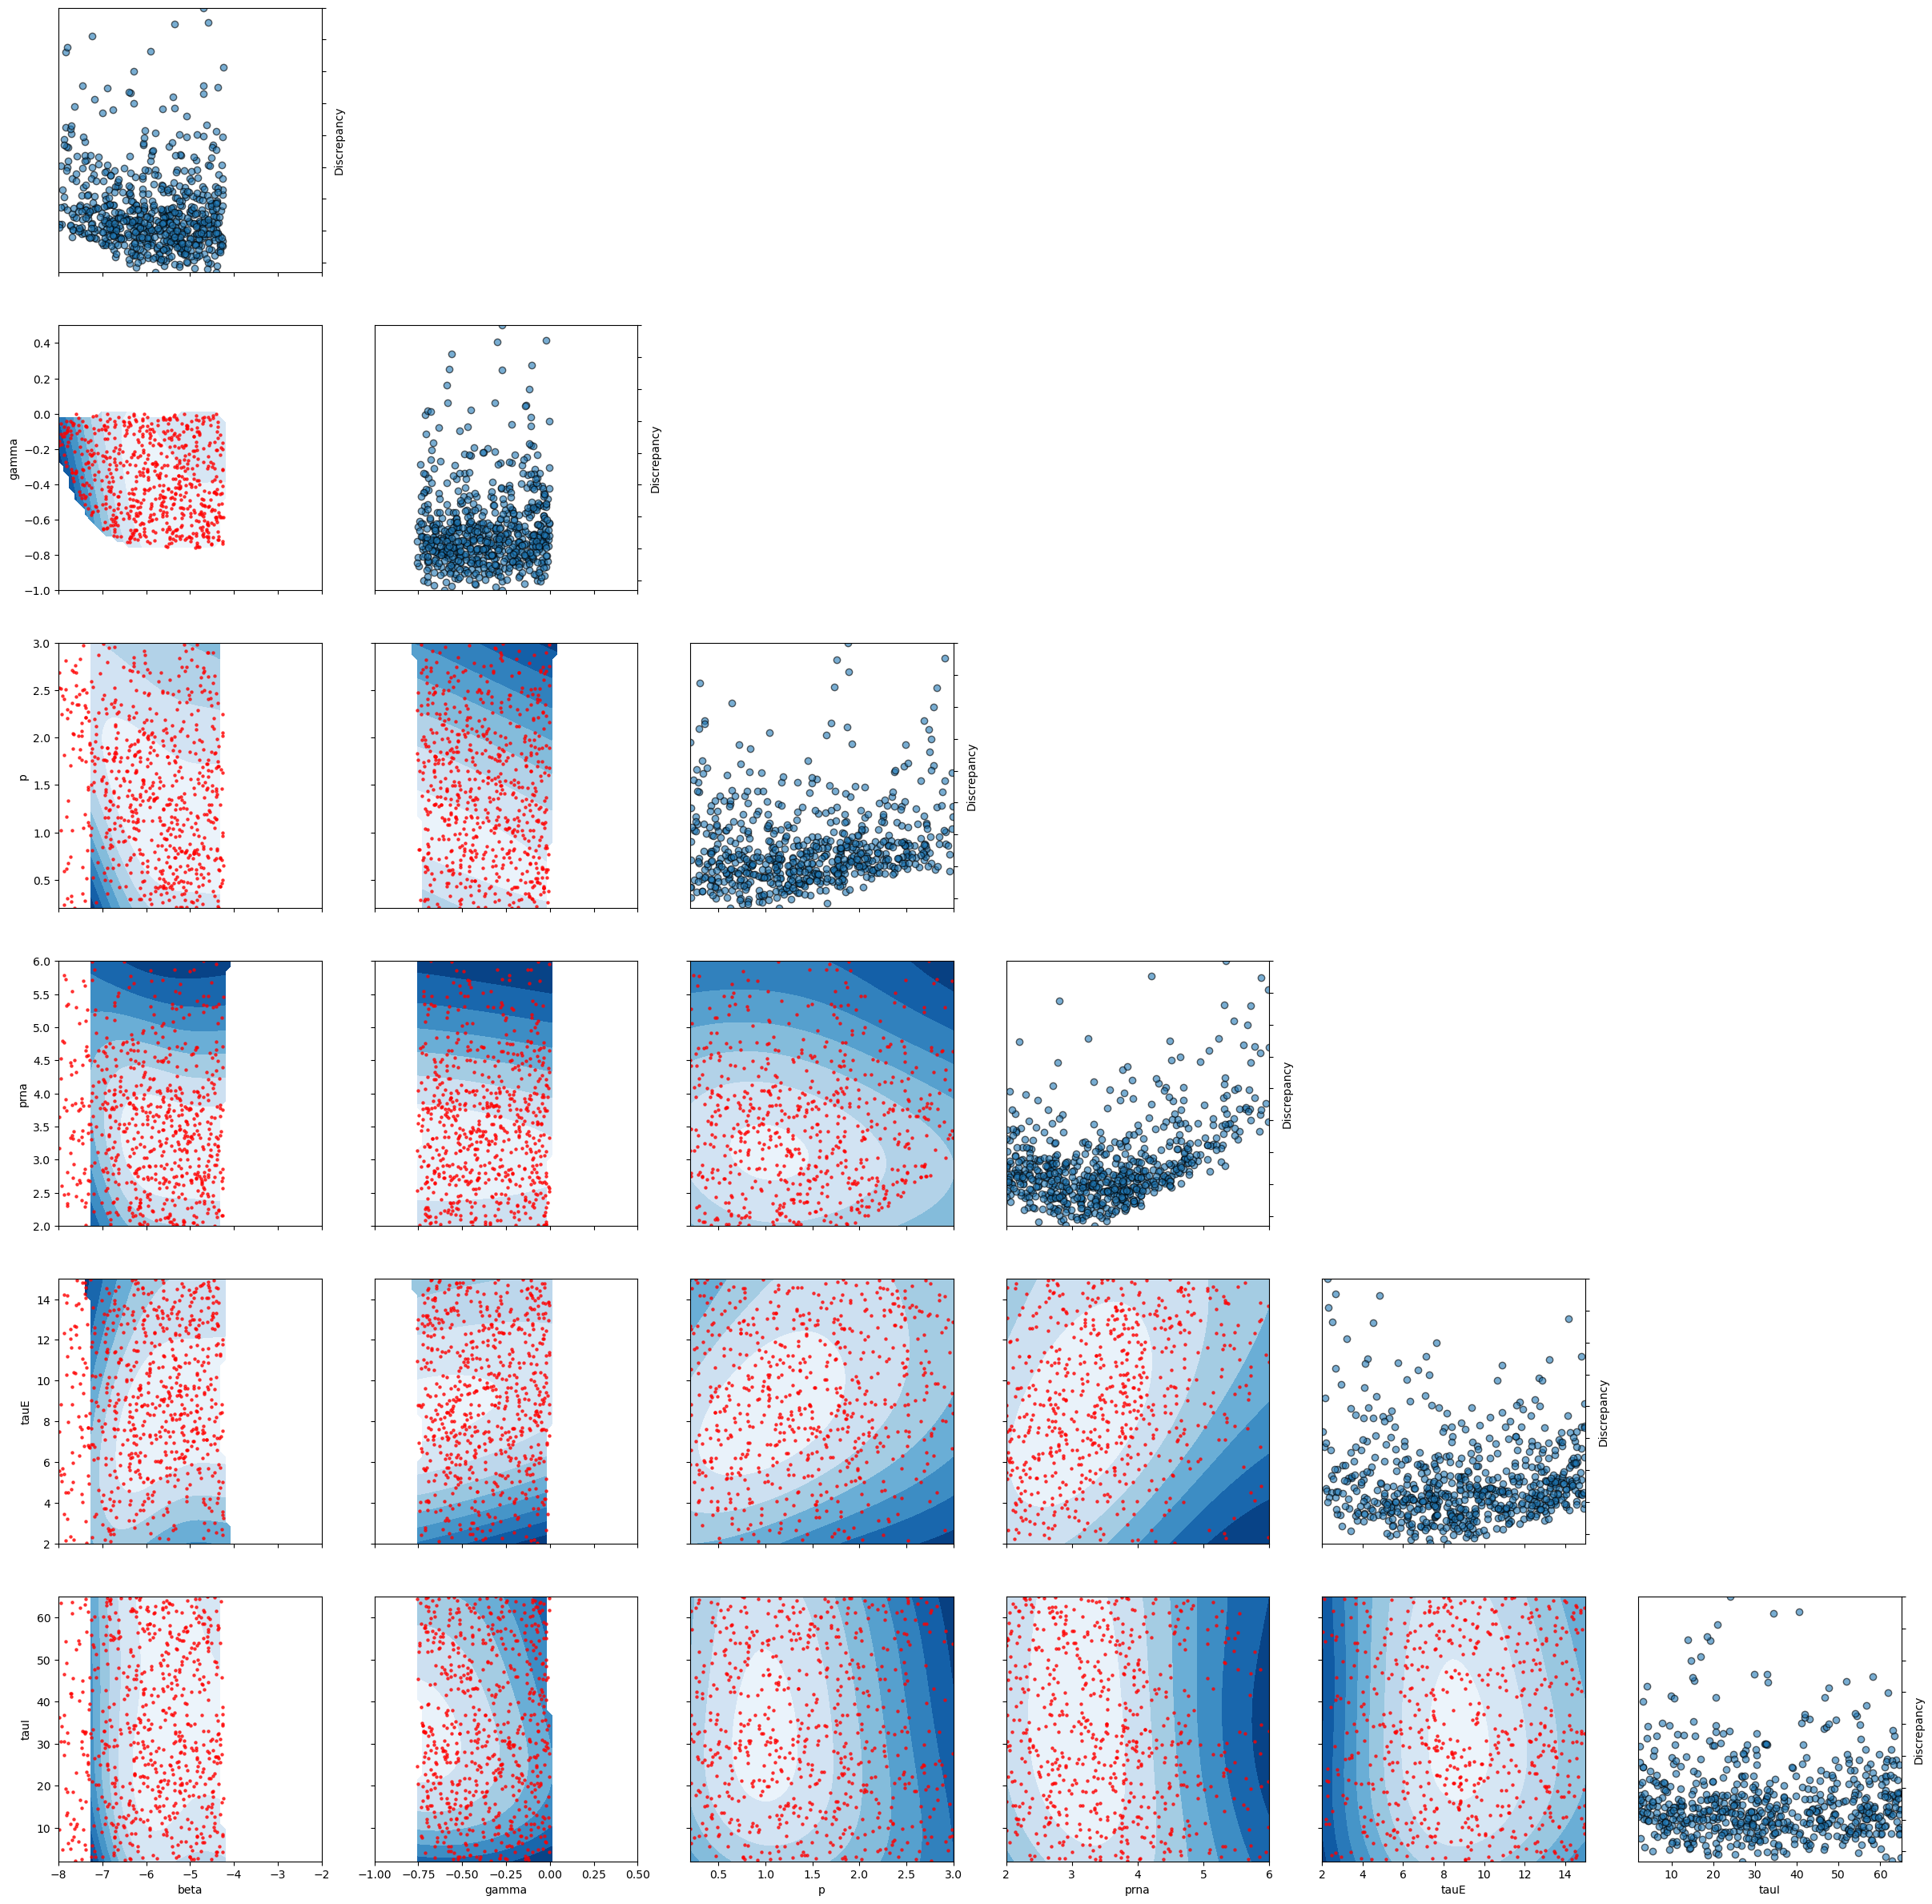

In [58]:
bolfi_2.plot_gp();

In [67]:
pdic, t_samples, D = simulator.load()

para_true={'p': np.log10(pdic['p']),
 'beta': np.log10(pdic['beta']),
 'gamma': np.log10(pdic['gamma']),
 'prna': np.log10(pdic['prna']),
 'tauE': 7,
 'tauI': 41}
 #add true parameter value to the plot:

In [68]:
para_true

{'p': 0.6616939151272248,
 'beta': -5.5506639194632434,
 'gamma': -0.3010299956639812,
 'prna': 3.03,
 'tauE': 7,
 'tauI': 41}

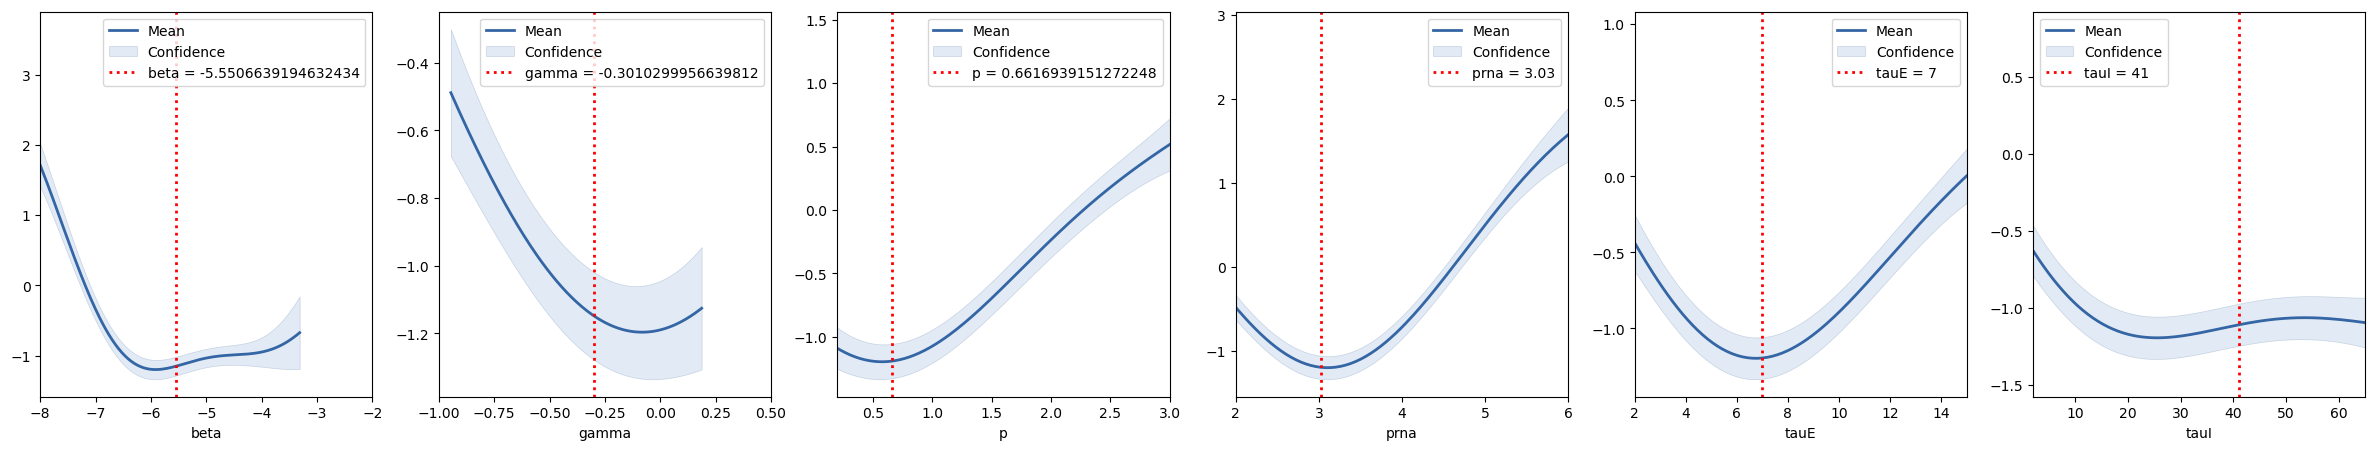

In [69]:
parameter_names = bolfi_2.target_model.parameter_names

# Generate the plot
plot_point = [optim_result.x_min[param] for param in parameter_names]
xlim = np.array([bounds[name] for name in m.parameter_names])
plot_1d_slices(bolfi_2.target_model.instance, plot_point, xlim, names=parameter_names)

# Retrieve the axes manually
axes = plt.gcf().get_axes()

# Extract the corresponding values from para_true
para_true_values = [para_true[param] for param in parameter_names]

# Add the red points to each subplot
for i, ax in enumerate(axes):
    param_value = para_true_values[i]
    #ax.scatter(param_value, 0, color='red', marker='o', label=f"{parameter_names[i]} = {param_value}")
    ax.axvline(param_value, color='red', linestyle=':', linewidth=2, label=f"{parameter_names[i]} = {param_value}")

# Optionally, add a legend to each subplot
for ax in axes:
    ax.legend()

# Show the plot
plt.show()

In [70]:
pred = lambda x: bolfi_2.target_model._gp.predict(x)[0]

related to failed simulations:

In [75]:
bolfi_2.target_model.n_evidence_all  # num simulations

1000

In [76]:
bolfi_2.target_model.n_evidence  # num simulations that produced output

649

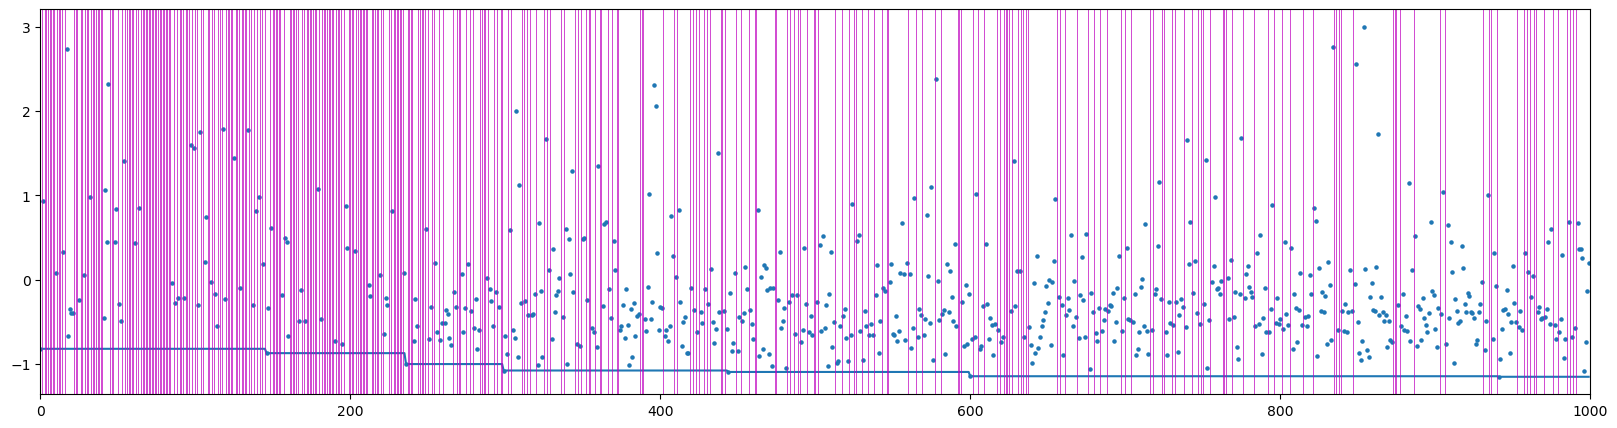

In [77]:
plt.figure(figsize=(20, 5))
plt.plot(np.minimum.accumulate(bolfi_2.target_model.Y_all))
plt.scatter(np.arange(bolfi_2.target_model.n_evidence_all), bolfi_2.target_model.Y_all, s=5)
plt.xlim(0, len(bolfi_2.target_model.Y_all))
for n in range(bolfi_2.target_model.n_evidence_all):
    if not np.isfinite(bolfi_2.target_model.Y_all[n]):
        plt.axvline(n, color='m', linewidth=0.5)

check predictions

In [83]:
n_test = 20
pred = {'s1': [], 's2': [], 's3': [], 's4': []}
test_params = {param: float(optim_result.x_min[param]) for param in m.parameter_names}
for n in range(n_test):
    out = meanfield_simulator(test_params['gamma'], test_params['p'], test_params['beta'], test_params['prna'], test_params['tauE'], test_params['tauI'], setup)
    pred['s1'].append(out[0][:, -8:])
    pred['s2'].append(out[1][:, 1])
    pred['s3'].append(out[2][:, -8:])
    pred['s4'].append(out[3][:, 1])

In [84]:
# using synthetic data for comparison 

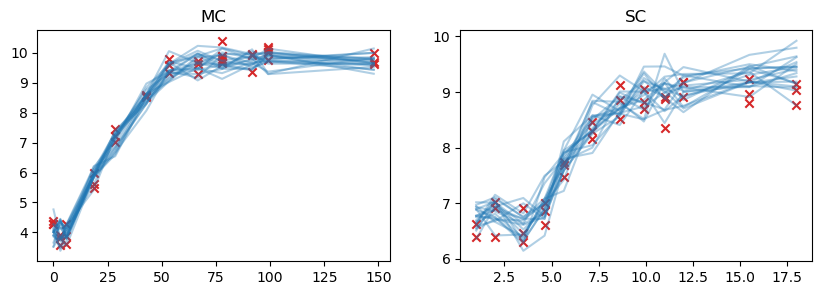

In [85]:
f, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(t_samples['MC'], np.log10(np.array(pred['s2'])).transpose(), color='C0', alpha=0.35);
ax[0].scatter(sim_dat_multi[1][:, 0], np.log10(sim_dat_multi[1][:, 1]), color='C3', marker='x') #change obs_dat_multi to sim_dat_multi
ax[1].plot(t_samples['SC'][1:], np.log10(np.array(pred['s4'])).transpose(), color='C0', alpha=0.35);
ax[1].scatter(sim_dat_multi[3][:, 0], np.log10(sim_dat_multi[3][:, 1]), color='C3', marker='x') #change obs_dat_multi to sim_dat_multi
ax[0].set_title('MC')
ax[1].set_title('SC');

In [86]:
n_test = 20
test_params = {param: np.random.permutation(result_BOLFI.samples[param])[:n_test] for param in m.parameter_names}
pred = {'s1': [], 's2': [], 's3': [], 's4': []}
failed_preds = []
for n in range(n_test):
    out = meanfield_simulator(test_params['gamma'][n], test_params['p'][n], test_params['beta'][n], test_params['prna'][n], test_params['tauE'][n], test_params['tauI'][n], setup)
    if out[0] is not None:
        pred['s1'].append(out[0][:, -8:])
        pred['s2'].append(out[1][:, 1])
        pred['s3'].append(out[2][:, -8:])
        pred['s4'].append(out[3][:, 1])
    else:
        failed_preds.append(n)

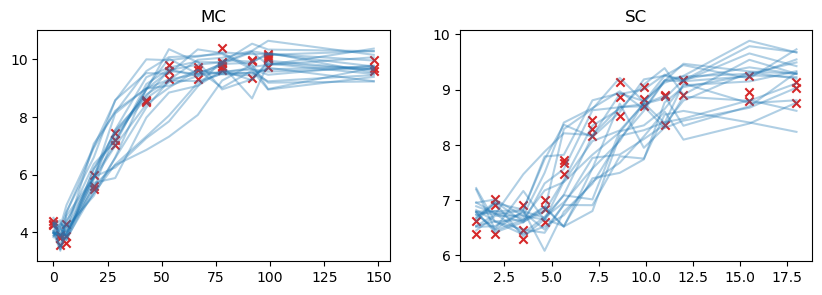

In [87]:
f, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(t_samples['MC'], np.log10(np.array(pred['s2'])).transpose(), color='C0', alpha=0.35);
ax[0].scatter(sim_dat_multi[1][:, 0], np.log10(sim_dat_multi[1][:, 1]), color='C3', marker='x')#change obs_dat_multi to sim_dat_multi
ax[1].plot(t_samples['SC'][1:], np.log10(np.array(pred['s4'])).transpose(), color='C0', alpha=0.35);
ax[1].scatter(sim_dat_multi[3][:, 0], np.log10(sim_dat_multi[3][:, 1]), color='C3', marker='x') #change obs_dat_multi to sim_dat_multi
ax[0].set_title('MC')
ax[1].set_title('SC');